In [1]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00


In [34]:
from transformers import BertTokenizer, TFBertModel

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DataPath = '/content/drive/MyDrive/random_reviews.csv'

Mounted at /content/drive


In [43]:
df = pd.read_csv(DataPath)

In [12]:
df.head()

,scores,reviews
0,2,Food was very disappointing. Most of the food ...
1,3,"The food and service here is good. However, ha..."
2,5,If u want to relax have the best drinks and mo...
3,2,I went along with my friends to this restauran...
4,2,If good food is what u want to eat look somewh...


In [44]:
#If we wanted to make things easier, we could also group scores of 1,2 = 0 and 4,5 = 0 and discard 3.
#i.e. focus on strongly positive and negative reviews only, but there could be some information loss.
df['scores'] = [1 if score >= 3 else 0 for score in df['scores']]
reviews = df['reviews'].values.tolist()
scores = np.array(df['scores'].values)

In [45]:
df.head()

,scores,reviews
0,0,Food was very disappointing. Most of the food ...
1,1,"The food and service here is good. However, ha..."
2,1,If u want to relax have the best drinks and mo...
3,0,I went along with my friends to this restauran...
4,0,If good food is what u want to eat look somewh...


In [46]:
df['scores'].value_counts()

1    13365
0     8910
Name: scores, dtype: int64

In [16]:
reviews[:2]

["Food was very disappointing. Most of the food was cold and the service terrible. Staff just didn't smile at all. Not reccommended.",
 "The food and service here is good. However, having been travelling in india for 6 months and now working in Delhi for the last month I was shocked by the prices here. The customers are 90% tourists as I'm guessing this is where taxis take punters for guaranteed good food. However, I have been to 5 star hotels here and paid less and had far nicer decor and a similar level of food/service..  If you want authentic stay away from here. If you want have good food but don't mind paying a massive price for being a tourist then go ahead."]

In [17]:
scores[:2]

array([0, 1])

In [18]:
#Setting max length param
max_length = 128

In [10]:
#Bunch of BERT commands
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [28]:
# tokenize the dataset, truncate when passed `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
encodings = bert_tokenizer.batch_encode_plus(reviews,
                                        add_special_tokens = True,
                                        truncation = True,
                                        padding = 'max_length',
                                        max_length = max_length,
                                        return_attention_mask = True)

input_ids = np.array(encodings['input_ids'])
attention_masks = np.array(encodings['attention_mask'])

In [27]:
#Check input ids
#encodings.input_ids[:1]

In [30]:
#Split data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(input_ids, scores, attention_masks,
                                                                                              test_size = 0.2, random_state = 42)

In [55]:
def create_bert_binary_model(checkpoint = model_checkpoint,
                                 dropout = 0.3,
                                 learning_rate = 0.00005):
    """
    Build a simple classification model with BERT
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name ='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(input_id_model, attention_mask=attention_masks_model)[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(bert_out)
    output = Dropout(dropout)(output)
    output = Dense(1, activation='sigmoid')(output)

    classification_model = Model(inputs=[input_id_model, attention_masks_model], outputs=output)
    classification_model.layers[2].trainable = False

    classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classification_model

In [56]:
model = create_bert_binary_model(checkpoint = model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [57]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

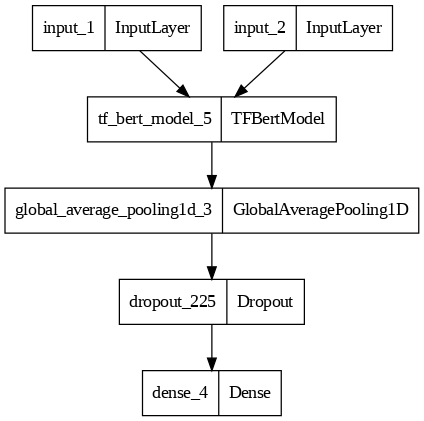

In [58]:
keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [59]:
history = model.fit([train_inputs, train_masks], train_labels, validation_data=([val_inputs, val_masks], val_labels),
                    batch_size = 64, epochs = 1)

279/279 [==============================] - 12284s 44s/step - loss: 0.4992 - accuracy: 0.7630 - val_loss: 0.3979 - val_accuracy: 0.8409


In [ ]:
# Model Evaluation
predictions = model.predict([val_inputs, val_masks])
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
accuracy = accuracy_score(val_labels, predictions)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(val_labels, predictions))